# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

In [185]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import wandb
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'): # '/kaggle/input'
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./simple-regression.ipynb
./winequality-red.csv
./wandb/debug-internal.log
./wandb/debug-cli.lorenzozanolin.log
./wandb/debug.log
./wandb/run-20231013_152213-1mdmbnvn/run-1mdmbnvn.wandb
./wandb/run-20231013_152213-1mdmbnvn/logs/debug-internal.log
./wandb/run-20231013_152213-1mdmbnvn/logs/debug.log
./wandb/run-20231013_152213-1mdmbnvn/files/requirements.txt
./wandb/run-20231013_152213-1mdmbnvn/files/output.log
./wandb/run-20231013_152213-1mdmbnvn/files/config.yaml
./wandb/run-20231013_152213-1mdmbnvn/files/wandb-metadata.json
./wandb/run-20231013_153847-h2jvr2b3/run-h2jvr2b3.wandb
./wandb/run-20231013_153847-h2jvr2b3/logs/debug-internal.log
./wandb/run-20231013_153847-h2jvr2b3/logs/debug.log
./wandb/run-20231013_153847-h2jvr2b3/files/requirements.txt
./wandb/run-20231013_153847-h2jvr2b3/files/output.log
./wandb/run-20231013_153847-h2jvr2b3/files/config.yaml
./wandb/run-20231013_153847-h2jvr2b3/files/wandb-summary.json
./wandb/run-20231013_153847-h2jvr2b3/files/wandb-metadata.json
./wand

First, we need to import Pytorch

In [186]:
import torch
from torch import nn
from torch import optim
from torch.utils import data
from sklearn.model_selection import train_test_split
#import wandb
#wandb.init(project="simple_regression")

# Data Processing

In [187]:
train_data = pd.read_csv('./winequality-red.csv')    #'/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
train_data.head()
train_data.shape

(1599, 12)

We need to separate features from target

In [188]:
n_train = train_data.shape[0]   #rows number
all_features = train_data.iloc[:, 0:-1] #features excluding the last column (quality), which is the label => features are X
#trains_labels   #labels representing the quality of the wine

Then we normalize the values

In [189]:
all_features = all_features.apply(lambda x: (x - x.mean()) / (x.std())) #normalization

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)   #create the tensor containing the features

trains_labels = train_data.quality.values.reshape(-1, 1)

trains_mean = trains_labels.mean()
trains_std = trains_labels.std()
trains_labels = (trains_labels - trains_mean) / trains_std  #normalization
train_labels = torch.tensor(trains_labels,          #tensor containing the normalized training labels
                            dtype=torch.float32)
train_labels.shape

torch.Size([1599, 1])

Finally, We split the training set in two parts: *training* and *test* set.

In [190]:
X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_labels,test_size=0.25)

## Training

Initialize the weights and bias of the linear regression

In [191]:
n_features = train_features.shape[1] 
weights = torch.randn((n_features),requires_grad=True) # TODO, initialize a random tensor of weights, one weight for each feature
bias = torch.zeros(1, requires_grad=True)
#weights,bias

Some functions definitions

In [192]:
from matplotlib import pyplot as plt


def linreg(X, w, b):        #linear regression
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):    #we will use stochastic GD
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
criterion = nn.MSELoss()    #the loss function will be mean squared error

def data_iter(batch_size, features, labels):    #to divide a single batch in multiple minibatches
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def print_result(true_value, predicted_value):
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')
    #plt.yscale('log')
    #plt.xscale('log')

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

Training loop

In [193]:
# MINI BATCH, calculate for each round the derivative for each minibatch, and then sum up them together
num_iterations = 512
batch_size = 16
lr = 1e-3
print('Training loss:')
for i in range(num_iterations):
    for X, y in data_iter(batch_size, X_train, Y_train):    
        loss = squared_loss(linreg(X,weights,bias),y)    #calculate the prediction, i.e. X(train features) * weights +b; then the loss w.r.t. labels
        loss.sum().backward() #derivate calc
        sgd([weights,bias],lr,batch_size)   #update weights
    with torch.no_grad():
        train_l = squared_loss(linreg(X, weights, bias), y)
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')
    

Training loss:
epoch 1, loss 3.773190
epoch 2, loss 5.056015
epoch 3, loss 1.237505
epoch 4, loss 1.514147
epoch 5, loss 2.095552
epoch 6, loss 1.463410
epoch 7, loss 2.001467
epoch 8, loss 1.715247
epoch 9, loss 0.845880
epoch 10, loss 1.086460
epoch 11, loss 1.055185
epoch 12, loss 0.752443
epoch 13, loss 1.545702
epoch 14, loss 0.542035
epoch 15, loss 0.435351
epoch 16, loss 0.860191
epoch 17, loss 0.952923
epoch 18, loss 1.139221
epoch 19, loss 0.262630
epoch 20, loss 0.270635
epoch 21, loss 1.266517
epoch 22, loss 0.331235
epoch 23, loss 0.496050
epoch 24, loss 0.978201
epoch 25, loss 0.892791
epoch 26, loss 0.445267
epoch 27, loss 0.963655
epoch 28, loss 0.555796
epoch 29, loss 0.392373
epoch 30, loss 0.648000
epoch 31, loss 0.296245
epoch 32, loss 0.682549
epoch 33, loss 0.180795
epoch 34, loss 0.592481
epoch 35, loss 0.608848
epoch 36, loss 0.474196
epoch 37, loss 0.282867
epoch 38, loss 0.512490
epoch 39, loss 0.579537
epoch 40, loss 0.225090
epoch 41, loss 0.232002
epoch 42, 

## Testing

We need to calculate the loss also over the test set

In [194]:
# test on the test dataset
with torch.no_grad():
    test_l = 0
    for X, y in data_iter(batch_size, X_test, Y_test):
        test_l += squared_loss(linreg(X, weights, bias), y).sum()
    test_l /= len(X_test)
    print(f'loss on the test dataset {float(test_l):f}')

loss on the test dataset 0.325748


## Results

Finally, the obtained predictions are the following

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


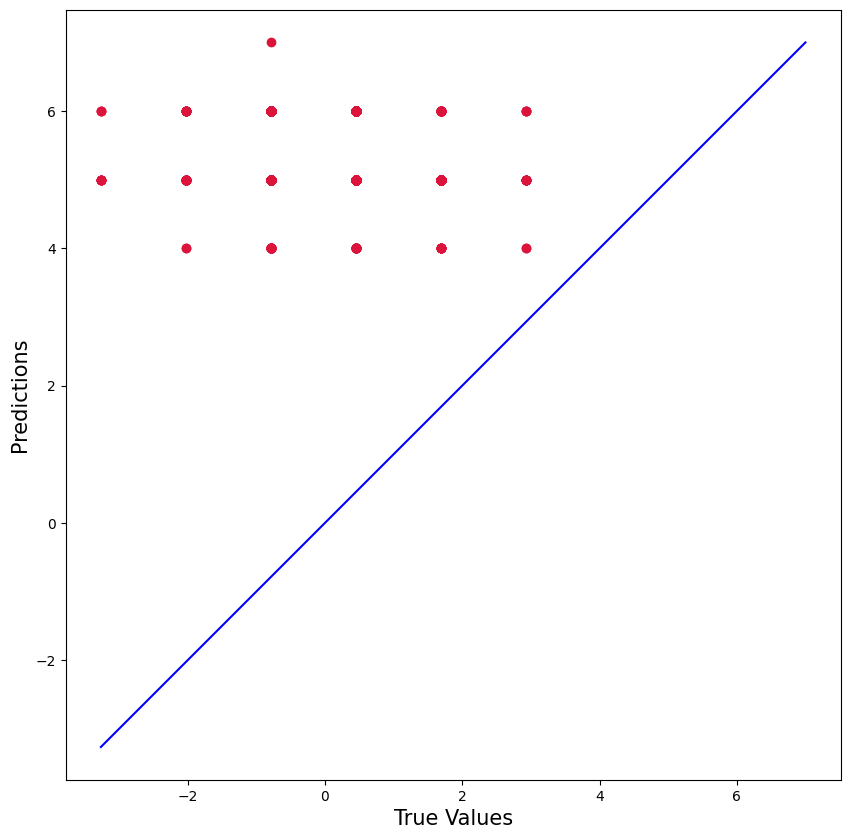

In [199]:
train_predictions = linreg(X_train,weights,bias)
train_predictions = torch.floor((train_predictions * trains_std) + trains_mean)  #denormalization + floor approximation

test_predictions = linreg(X_test,weights,bias)
test_predictions = torch.floor((test_predictions * trains_std) + trains_mean)  #denormalization + floor approximation
with torch.no_grad():
    print_result(train_labels,torch.cat((train_predictions,test_predictions),0))

#print(train_predictions,test_predictions)